In [3]:
import pandas as pd
df = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/Brave/final_fragments_summary.csv")
# change the category and only take the last element after the last ,
df['GeneName'] = df['Origin_seq'].apply(lambda x: x.split(',')[-1])

In [4]:
df.head()

,Group,Origin_seq,LUTnr,AAstart,AAend,Structure,Peptide,start,end,width,...,RNAcount,RNAcount_ratio,BC_count,BC_ratio,BC_adjusted_count_ratio,AAwidth,AAseqlength,AA_pos,AA_rel_pos,GeneName
0,DNA_AAVlib_DNAse_30cpc,"Adeno-associated virus,VP1,AAV1,,#125,AAV1-VP1",seq_10017,98,112,14aa,EFQERLQEDTSFGG,294,336,42,...,915.0,0.000175,10,0.000038,0.000194,14,736,105,0.142663,AAV1-VP1
1,DNA_AAVlib_DNAse_30cpc,"Adeno-associated virus,VP1,AAV1,,#125,AAV1-VP1",seq_10139,99,113,14aa,FQERLQEDTSFGGN,297,339,42,...,136.0,0.000026,7,0.000027,0.000039,14,736,106,0.144022,AAV1-VP1
2,DNA_AAVlib_DNAse_30cpc,"Adeno-associated virus,VP1,AAV1,,#125,AAV1-VP1",seq_10170,100,114,14aa,QERLQEDTSFGGNL,300,342,42,...,116.0,0.000022,8,0.000031,0.000038,14,736,107,0.145380,AAV1-VP1
3,DNA_AAVlib_DNAse_30cpc,"Adeno-associated virus,VP1,AAV1,,#125,AAV1-VP1",seq_1024,10,24,14aa,LEDNLSEGIREWWD,30,72,42,...,22.0,0.000004,1,0.000004,0.000006,14,736,17,0.023098,AAV1-VP1
4,DNA_AAVlib_DNAse_30cpc,"Adeno-associated virus,VP1,AAV1,,#125,AAV1-VP1",seq_10289,101,115,14aa,ERLQEDTSFGGNLG,303,345,42,...,134.0,0.000026,2,0.000008,0.000029,14,736,108,0.146739,AAV1-VP1


In [5]:
# get the number of unique LUTnr in each group of the dataframe
df.groupby('Group')['LUTnr'].nunique()

Group
DNA_AAVlib_DNAse_30cpc    69683
DNA_AAVlib_DNAse_3cpc     23035
DNA_pscAAVlib_Prep2       87151
DNAse_resistant_AAVs      70890
Infective_AAVs            24593
Plasmid_Library           83595
Transported_AAVs           3211
mRNA_30cpc_Ctx             4051
mRNA_30cpc_Ctx_4wks         146
mRNA_30cpc_HEK293T          212
mRNA_30cpc_SN              3088
mRNA_30cpc_SN_4wks          147
mRNA_30cpc_Str            11185
mRNA_30cpc_Str_4wks       17384
mRNA_30cpc_Th              3725
mRNA_30cpc_Th_4wks          223
mRNA_30cpc_pNeuron          321
mRNA_3cpc_Ctx               760
mRNA_3cpc_Ctx_4wks           11
mRNA_3cpc_HEK293T            76
mRNA_3cpc_SN                273
mRNA_3cpc_SN_4wks            55
mRNA_3cpc_Str              2252
mRNA_3cpc_Str_4wks          175
mRNA_3cpc_Th               2617
mRNA_3cpc_Th_4wks            62
mRNA_3cpc_pNeuron            34
Name: LUTnr, dtype: int64

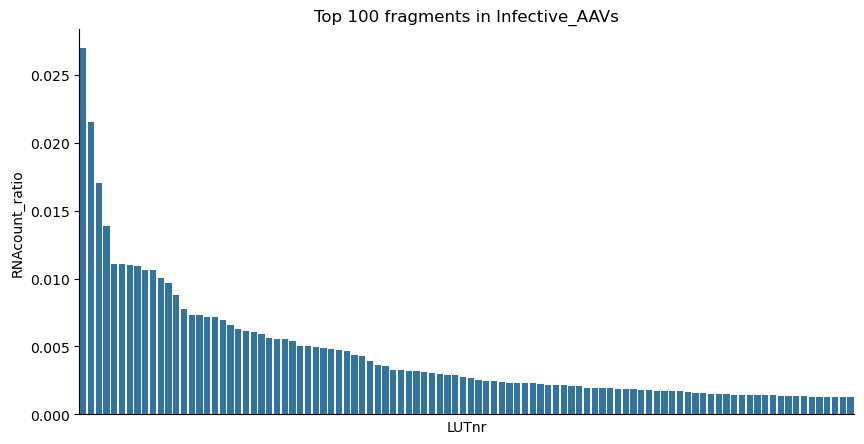

In [6]:
from plotting_functions import plot_top_counts
plot_top_counts(df, 100, 'Infective_AAVs', 'RNAcount_ratio')

posx and posy should be finite values
posx and posy should be finite values


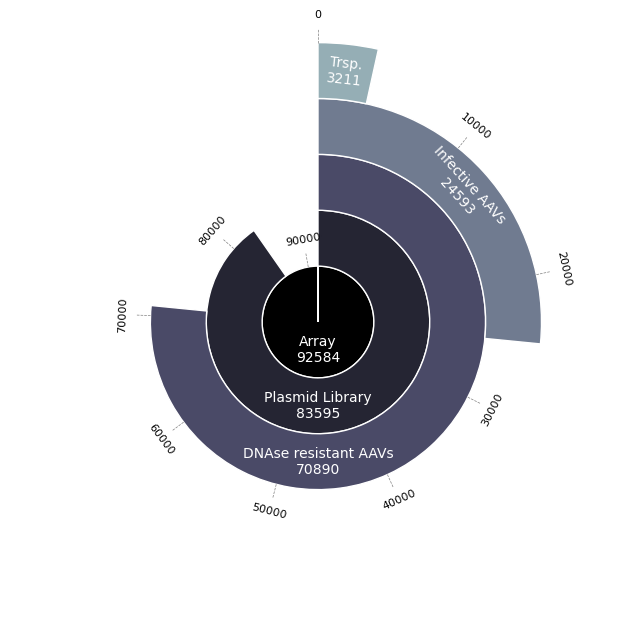

In [7]:
from plotting_functions import plot_quantities
plot_quantities(df,
                {'Plasmid_Library':'Plasmid Library', 'DNAse_resistant_AAVs':'DNAse resistant AAVs', 'Infective_AAVs': 'Infective AAVs', 'Transported_AAVs':'Trsp.'},
                {"Array": 92584})

In [8]:
# print all unique group names
print(df['Group'].unique())
# print all unqiue gene names
print(df['GeneName'].unique())

['DNA_AAVlib_DNAse_30cpc' 'DNA_AAVlib_DNAse_3cpc' 'DNA_pscAAVlib_Prep2'
 'DNAse_resistant_AAVs' 'Infective_AAVs' 'Plasmid_Library'
 'Transported_AAVs' 'mRNA_30cpc_Ctx' 'mRNA_30cpc_Ctx_4wks'
 'mRNA_30cpc_HEK293T' 'mRNA_30cpc_SN' 'mRNA_30cpc_SN_4wks'
 'mRNA_30cpc_Str' 'mRNA_30cpc_Str_4wks' 'mRNA_30cpc_Th'
 'mRNA_30cpc_Th_4wks' 'mRNA_30cpc_pNeuron' 'mRNA_3cpc_Ctx'
 'mRNA_3cpc_Ctx_4wks' 'mRNA_3cpc_HEK293T' 'mRNA_3cpc_SN'
 'mRNA_3cpc_SN_4wks' 'mRNA_3cpc_Str' 'mRNA_3cpc_Str_4wks' 'mRNA_3cpc_Th'
 'mRNA_3cpc_Th_4wks' 'mRNA_3cpc_pNeuron']
['AAV1-VP1' 'AAV6-VP1' 'AAV8-VP1' 'AAV9-VP1' 'BDV-G' 'BDV-CRNP5'
 'BDV-No/98' 'CAV-2-F-SH01' 'CAV-2-F-Toronto A26/61' 'CHIKV-Sp-1'
 'EV71-VP1-1095/Japan 97' 'EV71-VP1-FY23' 'EV71-VP1-cx2011-016' 'EV71-VP2'
 'EV71-VP3' 'EV71-VP4' 'BV-G' 'HSV-1-pUL1' 'HSV-1-pUL10' 'HSV-1-pUL14'
 'HSV-1-pUL16' 'HSV-1-pUL19' 'HSV-1-pUL21' 'HSV-1-pUL22' 'HSV-1-pUL27'
 'HSV-1-pUL35' 'HSV-1-pUL36' 'HSV-1-pUL37' 'HSV-1-pUL44' 'HSV-1-pUL53'
 'HSV-1-pUS4' 'HSV-1-pUS5' 'HSV-1-pUS6' 'HSV-

/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/Python_Scripts/Jupyter_notebooks/plotting_functions.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{abs(tick):.0f}' for tick in ax.get_yticks()])


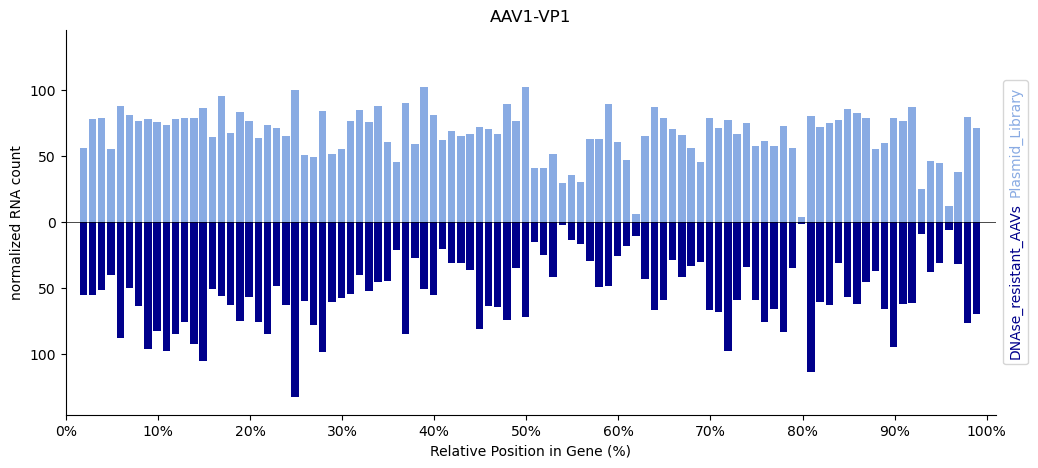

In [9]:
from plotting_functions import plot_rna_counts
df['normalized_RNAcount'] = np.log2(df['RNAcount']+1)
plot_rna_counts(df, "Plasmid_Library", "DNAse_resistant_AAVs", "AAV1-VP1", "normalized_RNAcount", "normalized RNA count")


In [10]:
def get_top_fragment(df, group, n, sort_by, strucutre):
    return df[(df['Group'] == group) & (df['Structure'] == strucutre)].nlargest(n, sort_by)

In [11]:
top_50_inf_aavs = get_top_fragment(df, "Infective_AAVs", 50, "BC_adjusted_count_ratio", "14aa")

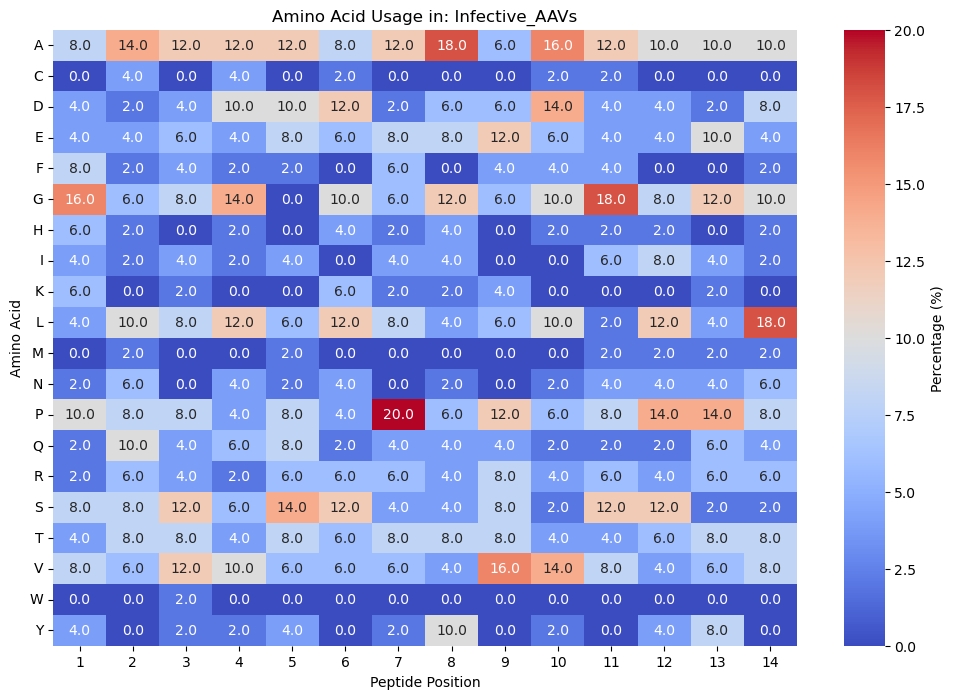

In [12]:
from plotting_functions import plot_amino_acid_heatmap
plot_amino_acid_heatmap(top_50_inf_aavs, "Infective_AAVs", "14aa")

In [13]:
import pandas as pd
import numpy as np
import logomaker
import matplotlib.pyplot as plt

def create_bit_information_logo(df: pd.DataFrame, structure: str=None):

    # Function to create bit information matrix
    def create_bit_information_matrix(peptides: list) -> pd.DataFrame:
        """
        Create a bit information matrix for peptides of the same length.
        
        Parameters
            peptides : list of str : A list of peptides of the same length.
            
        Returns
            pd.DataFrame : A DataFrame containing the bit information
        """
        # Validate that all peptides are the same length
        peptide_length = len(peptides[0])
        if not all(len(peptide) == peptide_length for peptide in peptides):
            raise ValueError("All peptides must be of the same length")

        # Create an empty frequency matrix
        amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
        freq_matrix = pd.DataFrame(0, index=amino_acids, columns=range(peptide_length))

        # Populate the frequency matrix
        for peptide in peptides:
            for i, amino_acid in enumerate(peptide):
                freq_matrix.loc[amino_acid, i] += 1

        # Normalize the matrix to get frequencies
        freq_matrix = freq_matrix.div(len(peptides))

        # Calculate Shannon entropy and bit information for each position
        bit_matrix = freq_matrix.copy()
        max_entropy = np.log2(len(amino_acids))  # log2(20)
        for col in freq_matrix.columns:
            # Shannon entropy
            entropy = -np.nansum(freq_matrix[col] * np.log2(freq_matrix[col].replace(0, np.nan)))
            # Information content
            ic = max_entropy - entropy
            # Scale frequencies by information content
            bit_matrix[col] = freq_matrix[col] * ic
            
        bit_matrix = bit_matrix.T

        return bit_matrix
    
    # if a structure is provided, filter the DataFrame
    if structure is not None:
        df = df[df["Structure"] == structure]
    
    # Compute the bit information matrix
    peptides = df["Peptide"].tolist()
    bit_matrix = create_bit_information_matrix(peptides)

    # Create a sequence logo using Logomaker
    logo = logomaker.Logo(bit_matrix,                         
                            color_scheme='chemistry',
                            vpad=.3,
                            width=.8)

    plt.ylabel("bits")
    plt.show()


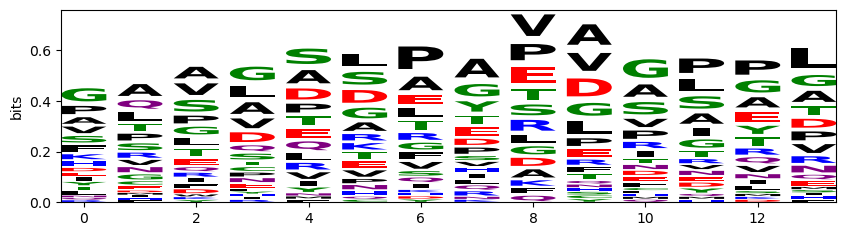

In [14]:
create_bit_information_logo(top_50_inf_aavs)

### For Motif search use MEME
meme sequences.fasta -protein -o meme_output_dir -nmotifs 10 -minw 5 -maxw 21